In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, point_cloud_generator,\
leaky_relu

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
save_model = False
do_training = True
plot_train_curve = False
save_synthetic_samples = np.hstack([np.array([1, 5, 10]), np.arange(50, 2001, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
# synthetic_data_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space//DATA/OUT/iclr/synthetic_samples/r_gan/'

Give me the class type.
car


In [5]:
n_pc_points = 2048
max_epochs = 2000
arch_tag = 'mlp_pc_gen_default_leak_20'

leak = 0.2
adaptive_training = None
beta = 0.5

discriminator = mlp_discriminator
generator = point_cloud_generator

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
init_lr = 0.0001

disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
gen_kwargs = {'b_norm': False}

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_points) +  '_pts'

In [6]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

751 pclouds were loaded. They belong in 1 shape-classes.
6372 pclouds were loaded. They belong in 1 shape-classes.
374 pclouds were loaded. They belong in 1 shape-classes.


In [7]:
training_data = in_data['train']
n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [ ]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_points, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.3724586466165978, 0.70457048350431783) 29.4001970291


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


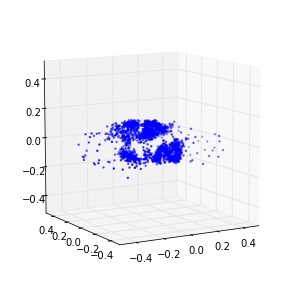

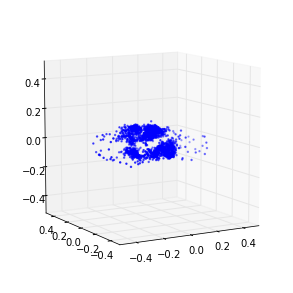

In [ ]:
save_syn_data_dir = create_dir(osp.join(synthetic_data_out_dir, experiment_name))

if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            
        if epoch in save_synthetic_samples:
            syn_data = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_data)
            np.savez(osp.join(save_syn_data_dir, 'epoch_' + str(epoch)), syn_data)            
            for k in range(2):
                Point_Cloud(syn_data[k]).plot()
        train_stats.append((epoch,) + loss)

In [ ]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')